In [1]:
import json

In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql import functions as f, SparkSession
from pyspark.sql.window import Window
from matplotlib import pyplot as plt
from pyspark.sql.types import IntegerType

In [3]:
spark = SparkSession.builder.appName('proj_b').getOrCreate()
sc = spark.sparkContext

In [4]:
df = spark.read.json(r"data.json")
df.printSchema()
df.count()

root
 |-- Arrival_Time: long (nullable = true)
 |-- Creation_Time: long (nullable = true)
 |-- Device: string (nullable = true)
 |-- Index: long (nullable = true)
 |-- Model: string (nullable = true)
 |-- User: string (nullable = true)
 |-- gt: string (nullable = true)
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- z: double (nullable = true)



546083

In [5]:
df_most_activity = df.groupBy("user", "gt").count()
df_sum_activity = df_most_activity.groupBy("user").sum("count")
df_sum_most = df_sum_activity.join(df_most_activity, ['user'])
df_avg_activity = df_sum_most.withColumn("avg", f.col('count')/f.col('sum(count)')).drop('sum(count)', 'count')
df_avg_activity.show()

+----+----------+-------------------+
|user|        gt|                avg|
+----+----------+-------------------+
|   g|      bike|0.12129333852746396|
|   g|       sit|0.15717958706661472|
|   g|     stand|0.14407479548110635|
|   g|  stairsup|0.10525905726529022|
|   g|stairsdown|0.10831320607713284|
|   g|      null|0.19094663030775225|
|   g|      walk|0.17293338527463967|
|   f|      walk|0.16467521181837932|
|   f|       sit|0.14251575059743646|
|   f|stairsdown|0.11821482883833524|
|   f|     stand|0.14371062350640887|
|   f|      bike|0.14653486856398001|
|   f|  stairsup|0.13509822786381553|
|   f|      null|0.14925048881164457|
|   e|      bike|0.15078621264188274|
|   e|stairsdown|0.10405974323500097|
|   e|     stand| 0.1398521295428512|
|   e|      walk| 0.1645319171092367|
|   e|      null|0.18181818181818182|
|   e|       sit|0.14516296990523794|
+----+----------+-------------------+
only showing top 20 rows



ראינו כי אחוז ביצוע פעילות כלשהי לכל משתמש נע בין 8 אחוזים ל20 אחוז

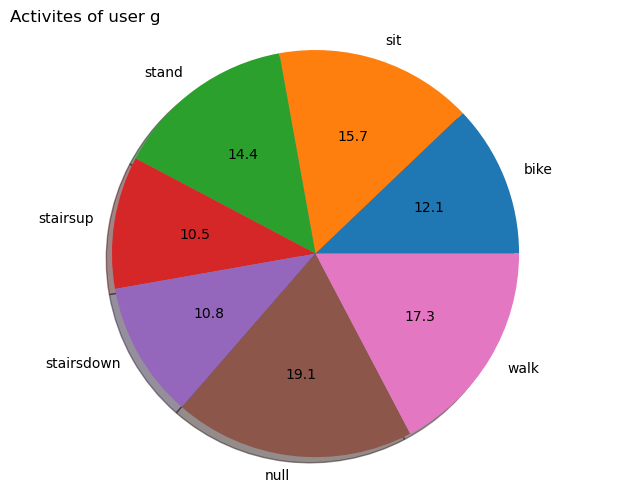

In [6]:
g_act = df_avg_activity.filter(f.col('user') == 'g').collect()
list_X = [row.gt for row in g_act]
list_Y = [row["avg"] for row in g_act]
fig, ax = plt.subplots()
ax.pie(list_Y, labels=list_X, shadow=True, autopct="%1.1f")
ax.axis("equal")
plt.tight_layout()
plt.title('Activites of user g', loc='left')
plt.show()

g זו התפלגות הפעילויות של 

In [7]:
df_time = df.withColumn("Arrival_Time", f.col("Arrival_Time") / 1000)
df_time = df_time.withColumn("Creation_Time", f.col("Creation_Time") / 10e8)
df_time = df_time.withColumn("Arrival_Time", f.from_unixtime(f.col("Arrival_Time")))
df_time = df_time.withColumn("Creation_Time", f.from_unixtime(f.col("Creation_Time")))
df_time.show(1)

+-------------------+-------------------+--------+-----+------+----+-----+------------+---------+-------------+
|       Arrival_Time|      Creation_Time|  Device|Index| Model|User|   gt|           x|        y|            z|
+-------------------+-------------------+--------+-----+------+----+-----+------------+---------+-------------+
|2015-02-23 12:18:55|2015-02-23 12:18:53|nexus4_1|   35|nexus4|   g|stand|0.0014038086|5.0354E-4|-0.0124053955|
+-------------------+-------------------+--------+-----+------+----+-----+------------+---------+-------------+
only showing top 1 row



In [8]:
hour = f.udf(lambda x: int(x.split(' ')[1].split(':')[0]))
df_hour = df_time.withColumn("hour", hour("Creation_Time"))
df_hour.groupBy("User", "gt").agg(f.mean("hour"), f.min("hour"), f.max("hour")).show(100)

+----+----------+------------------+---------+---------+
|User|        gt|         avg(hour)|min(hour)|max(hour)|
+----+----------+------------------+---------+---------+
|   d|stairsdown|14.884367321867321|       14|       15|
|   a|       sit|              15.0|       15|       15|
|   b|  stairsup| 15.51470247742533|       15|       16|
|   g|      bike|12.514131551901336|       12|       13|
|   i|     stand|              13.0|       13|       13|
|   i|      null|13.359491948287593|       13|       14|
|   a|      bike|15.543912175648703|       15|       16|
|   e|      bike|16.562647987371744|       16|       17|
|   f|      walk|              14.0|       14|       14|
|   h|      null|15.710843373493976|       15|       16|
|   h|stairsdown|              16.0|       16|       16|
|   c|      bike|14.559344479390829|       14|       15|
|   f|       sit|              14.0|       14|       14|
|   c|      walk|              14.0|       14|       14|
|   i|  stairsup|13.50450664136

In [9]:
day = f.udf(lambda x: x.split(' ')[0])
df_day = df_time.withColumn("day", day("Creation_Time"))
df_day.show()

+-------------------+-------------------+--------+-----+------+----+-----+-------------+-------------+-------------+----------+
|       Arrival_Time|      Creation_Time|  Device|Index| Model|User|   gt|            x|            y|            z|       day|
+-------------------+-------------------+--------+-----+------+----+-----+-------------+-------------+-------------+----------+
|2015-02-23 12:18:55|2015-02-23 12:18:53|nexus4_1|   35|nexus4|   g|stand| 0.0014038086|    5.0354E-4|-0.0124053955|2015-02-23|
|2015-02-23 12:18:55|2015-02-23 12:18:53|nexus4_1|   76|nexus4|   g|stand|-0.0039367676|  0.026138306|  -0.01133728|2015-02-23|
|2015-02-23 12:18:55|2015-02-23 12:18:53|nexus4_1|  115|nexus4|   g|stand|  0.003540039| -0.034744263| -0.019882202|2015-02-23|
|2015-02-23 12:18:55|2015-02-23 12:49:41|nexus4_2|  163|nexus4|   g|stand|  0.002822876|  0.005584717|  0.017318726|2015-02-23|
|2015-02-23 12:18:55|2015-02-23 12:49:42|nexus4_2|  203|nexus4|   g|stand| 0.0017547607| -0.018981934| -